# Dotingestion 2:
### there is no Dotingestion 1

## What is [Dota 2](https://www.dota2.com/home)?

<img src="https://i.pinimg.com/originals/8a/8b/50/8a8b50da2bc4afa933718061fe291520.jpg" alt="Dota 2 logo" style="width: 600px;" style="margin: auto;"/>

Dota 2 is a multiplayer online battle arena (MOBA) video game developed and published by Valve.
Ten players, split into two teams of five, compete to destroy a large structure defended by the opposing team known as the "Ancient", whilst defending their own.
The game is controlled using standard real-time strategy (RTS) controls, and is presented on a single map in a three-dimensional isometric perspective.

## But one does not simply play Dota...


<img src="https://i.stack.imgur.com/GIkIj.jpg" alt="Dota 2 map" style="width: 90%;"/>

What makes the game very enjoyable for veteran players (and extremely hard to get into for newbies) is the incredible depth of the game mechanics.
Just to give an idea, at the beginning of each game the players have to choose a hero, the character they will play for the rest of the match.
With a hero pool of over 120 heroes, each with 4 (or more) unique abilities, there are more than 10^14 possible team combinations!
And this without taking into consideration the many ways each hero can be played, which go from some minor changes to drastic alterations on one's role in the team.

## If you are good at something, never do it for free...

<img src="https://img.redbull.com/images/q_auto,f_auto/redbullcom/2018/01/02/976bd59b-e905-4d7d-9f96-0c206c1b66e3/dota2-valve-prize-pool-history" alt="international" style="width: 90%;"/>

**The International** is Dota's annual esports world championship tournament.
Starting with The International 2013 onward, the tournament's prize pool began to be crowdfunded through a type of in-game battle pass called the "Compendium", which raises money from players buying them to get exclusive in-game virtual goods and other bonuses. 25% of all the revenue made from yearly Compendiums goes directly to the prize pool. Each iteration of The International has surpassed the previous one's prize pool, with the last one, going over $40,000,000!

## Dota is data, and knowledge is power

<img src="https://www.dotabuff.com/assets/pages/app/app_screenshot_2-ee6f3476d62004d200e4cd3b696e7a8d0fc631c8b075a854c319b6b255cfeeee.png" alt="Dotabuff" style="width: 80%;"/>

<img src="https://dota2freaks.com/wp-content/uploads/sites/10/2020/03/Benchmarks-in-OpenDota-1024x545.png" alt="Opendota" style="width: 90%;"/>

Each Dota match is pretty unique in more than one way, and the fact that there are so many possibilities can be overwhelming, even for experienced players.
For this reasons, some services like [Dotabuff](https://www.dotabuff.com/) or [OpenDota](https://www.opendota.com/) have had great success with the player base, since they allow an in-depth analysis of a given game, showing, for example, the most successful builds or the best heroes of the meta.

## The project's goal

The goal of this project is to create a toned-down version of the [OpenDota](https://www.opendota.com/) project.
This means creating an ETL pipeline that ingests the data from all matches as they end, analyzes the data, and stores it, so that it can be fetched easily later.
In addition, a simple LinearRegression algorithm, trained on all the matches, will try to predict the winning team based only on the hero lineup.

## So, how do we do it?

In one image:

<img src="img/Dotingestion2-Pipeline.svg" alt="pipeline" style="height: 90%;"/>

Now, let's go step by step...

## Steam Web API <img src="https://cdn.freebiesupply.com/images/large/2x/steam-logo-transparent.png" alt="steam" style="height: 50px; float: left;"/>

All the matches data is fetched directly from the official Steam Web API.  
This is to achieve the **true adventurer experience ®️**.

In reality, there are some more refined APIs out there that provide the same data, often already enriched with many useful additional pieces of information. One such API is **OpenDota's**.

But then it would get

<img src="img/2ez4rtz.jpg" alt="2ez4rtz" style="width: 60%;"/>

Instead, we do it as any of the other APIs have to do: we use the original source.

## Steam Web API response <img src="https://cdn.freebiesupply.com/images/large/2x/steam-logo-transparent.png" alt="steam" style="height: 50px; float: left;"/>

<img src="img/Dotingestion2-SteamSchema.svg" alt="steam json schema" style="height: 700px;"/>

The json response from the Steam Web API has a [large number of fields](https://wiki.teamfortress.com/wiki/WebAPI/GetMatchDetails#Tower_Status).  
We are specifically interested in the list of matches it provides. 

While nowadays they mostly follow this schema, keep in mind that some fields are optional and that, in the past, many fields were not present at all.

## Steam Web API - go deeper <img src="https://cdn.freebiesupply.com/images/large/2x/steam-logo-transparent.png" alt="steam" style="height: 50px; float: left;"/>

The _GetMatchHistoryBySequenceNum_ endpoint used for fetching all the matches data requires a *Start_at_match_seq_num* parameter.

Its value when initialized depends on the _settings.yaml_ configuration file: 
- The sequential match id (int) of the first match you want to fetch
- 'cassandra', will fetch the last sequential match id in the cassandra database
- 'steam', will fetch the most recent sequential match id from the "hystory_endpoint"

After that, it will be the last match's match_seq_num + 1

```python
# Global variable that holds the match_seq_num to use in the API request
match_seq_num = None

# Read the configuration file
with open("settings.yaml", 'r', encoding='utf-8') as f:
                config = yaml.safe_load(f)


# Initialize the match_seq_num variable, depending on the value found in the configuration file
def get_match_seq_num(config: dict):
    if config['match_seq_num'] is None or config['match_seq_num'] == "steam":
        result = requests.get(config['hystory_endpoint'].format(config['api_key'])).json()
        matches = result['result'].get('matches', None)
        if matches:
            return matches[0]['match_seq_num']
    elif config['match_seq_num'] == "cassandra":
        from cassandra.cluster import Cluster
        cluster = Cluster(['cassandra'])
        session = cluster.connect("dota_ks")
        rows = session.execute('SELECT MAX(match_seq_num) FROM matches LIMIT 1')
        for row in rows:
            return row[0]
    elif isinstance(config['match_seq_num'], int):
        return config['match_seq_num']

    raise TypeError("match_seq_num must be either 'cassandra', 'steam', null or a integer")
```

## Steam Web API - notes <img src="https://cdn.freebiesupply.com/images/large/2x/steam-logo-transparent.png" alt="steam" style="height: 50px; float: left;"/>

- the idea is that it should be "as stupid as possible"

- it could be replaced with a bash script, although python is more convenient

## Kafka <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Apache_kafka.svg/295px-Apache_kafka.svg.png" alt="kafka" style="height: 50px; float: left; padding-right: 10px"/>

<img src="img/Dotingestion2-Pipeline.svg" alt="pipeline" style="height: 100%;"/>

All the data fetched from the Steam Web API is then submitted to Kafka, which will act as the "core" of the pipeline.  
All the data will pass through the Kafka cluster, and the Kafka topics will ensure that each kind of data reaches the intended consumer.

| Index | Service | From Kafka | To Kafka |
| - | - | - | - |
| 1 | Steam Web API | / | dota_raw |
| 2 | Kafka Streaming | dota_raw | dota_single - dota_lineup |
| 3 | Cassandra | dota_single | / |
| 4 | Dotingestio2 API | dota_request | dota_response |
| 5 | Spark | dota_lineup - dota_request | dota_response |
| 6 | Elasticsearch | dota_single | / |

## Kafka - notes<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Apache_kafka.svg/295px-Apache_kafka.svg.png" alt="kafka" style="height: 50px; float: left; padding-right: 10px"/>

- right now there is only one node, but that number could seamlessly go up

- zookeeper is there, for now...

## Kafka Streaming <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Apache_kafka.svg/295px-Apache_kafka.svg.png" alt="kafka" style="height: 50px; float: left; padding-right: 10px"/>

Right now, in the *dota_raw* topic we have the raw response from the Steam Web API. Some refining is in order.  
This is the task of the Kafka Streaming node.

It actually outputs two streams:

- **dota_single**
  -  cleans the raw input data, splits it by match and enriches each match with some useful data like the version of the game, the location, and the timestamp

- **dota_lineup**
  - for each match, creates a stream with messages containing the lineup of both teams, the winning team, and the match_seq_num

## Kafka Streaming - go deeper <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Apache_kafka.svg/295px-Apache_kafka.svg.png" alt="kafka" style="height: 50px; float: left; padding-right: 10px"/>

The stream code is just a standard java application.

The use of the Kafka library closely resembles the classic java streams sintax.

It is very easy to split the stream and create more than one output topic from an input stream.

```java
static void createStream(final StreamsBuilder builder) {
    final Serde<String> stringSerde = Serdes.String();

    final KStream<String, String> matches_raw = builder.stream(inputTopic, Consumed.with(stringSerde, stringSerde));

    final KStream<String, JSONObject> matches_single = matches_raw.flatMapValues(MatchesRefiner::splitMatches)
    .filter(MatchesRefiner::isValidMatch);

    // dota_single topic
    matches_single.flatMapValues(MatchesRefiner::enrichMatch).flatMapValues(MatchesRefiner::jsonToString)
    .to(outputTopicMatch, Produced.with(stringSerde, stringSerde));

    // dota_lineup topic
    matches_single.flatMapValues(MatchesRefiner::createLineup).flatMapValues(MatchesRefiner::jsonToString)
    .to(outputTopicLineup, Produced.with(stringSerde, stringSerde));
}
```

## Kafka Streaming - notes <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Apache_kafka.svg/295px-Apache_kafka.svg.png" alt="kafka" style="height: 50px; float: left; padding-right: 10px"/>

- it uses the standard _"org.apache.kafka"_ library for streaming, but is a simple java application

- its enrichment task is very simple, so using something like Spark at this step would probably be an overkill

- to make the service really interesting, the match replay associated with each match would need to be analyzed.  
  This could be done at this step, but it is [not as simple](https://github.com/odota/core/issues/703) as it may seem...

## Cassandra <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5e/Cassandra_logo.svg/1024px-Cassandra_logo.svg.png" alt="kafka" style="height: 50px; float: left; padding-right: 10px"/>

All this data has to be stored somewhere, and a possible "where" is Cassandra.  
Cassandra is a distributed, wide-column, NoSQL database management system designed to handle large amounts of data.

<img src="img/Dotingestion2-CassandraMin.svg" alt="Kafka" style="height: 600px;"/>

## Cassandra - notes<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5e/Cassandra_logo.svg/1024px-Cassandra_logo.svg.png" alt="kafka" style="height: 50px; float: left; padding-right: 10px"/>

- it is the backup database of the whole system. It means that, if something goes wrong, it should be always possible to recover from the data stored there

- it acts as a simple data warehouse

- the connection with Kafka is through a Kafka-connect node

- while a fully UDT version of the database schema is possible, the high variance of the field make so that is more convenient to use a text field to store the nested json

- using the match\_seq\_num as a clustering column means that it can be used to order the results in a select query

## Spark 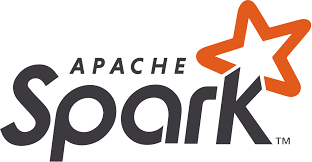

Until now, the match enrichment was limited to a few fields added and some filtering.  
Spark adds Machine Learning to the table.

The model is trained to "guess" the winning team from the lineup of both teams.

The accuracy, as you may see in the detailed [SparkModel](SparkModel.ipynb) notebook, is around 57%.  
It seems that the optimal results one could expect are around 60% ([source](https://www.reddit.com/r/DotA2/comments/gf1zgx/i_used_deep_learning_to_predict_dota_2_win/))

While the result may seem very low, it makes sense. 
In most games, the picks are very balanced, meaning that neither team has an advantage, and the outcome depends purely on the skill of the players involved.
A high prediction rate would indicate that most games are won at the pick stage, which wouldn't be very fun.

## Spark 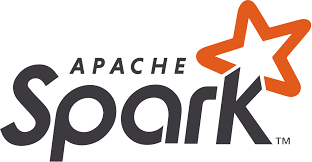

The data enrichment Spark provides is used to enrich the data already stored in elasticsearch, as well as providing a backend to the user requests for a specific lineup coming from the Dotingestion2 API.

A single Spark application can handle both streams, as long as the right settings are put in place.

## Spark - go deeper 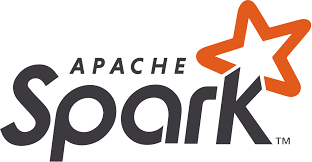

The preprocessing part is very similar to the one described in detail in the [SparkModel](SparkModel.ipynb) notebook, so only the parts related to the structured streaming. The same is true for the _"api"_ part.

This is the first part of every structured steam: df is a data frame that will keep growing as long as new messages come through Kafka

```python
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", kafkaServer) \
    .option("subscribe", topic) \
    .option("startingOffsets","earliest") \
    .load()
```

## Spark - go deeper 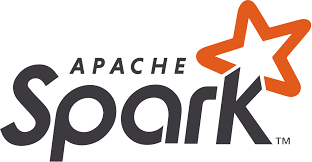

The process_data function combines all the convert functions and finally applies the ml model, exactly as one would do in a non-streaming scenario.

The only catch is that some **VectorSizeHint** stages had to be used in the pipeline to make this so seamless.

```python
def process_data(df: DataFrame, ml_model: PipelineModel = model) -> DataFrame:
    df = convert_types_for_ml(df)
    df = convert_heroes_to_lineup(df)
    df = ml_model.transform(df)
    df = convert_types_for_es(df)

    return df.select("probability_arr", "radiant_win_prediction", "match_seq_num")

df = process_data(df)
```

## Spark - go deeper 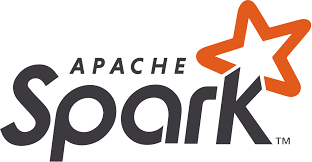

Finally, write the stream to elasticsearch

```python
# Write the stream to elasticsearch
query = df.writeStream \
          .option("checkpointLocation", "./checkpoints") \
          .format("es") \
          .start(elastic_index)
```

## Spark - notes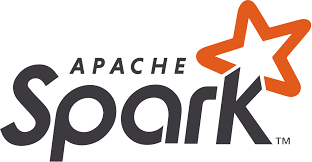

- spark's role is to enrich the data already present in elasticsearch with the win prediction and its probability

- the model only needs the 10 hero's id played by the two teams to estimate the winner

## Elasticsearch <img src="https://4.bp.blogspot.com/-SeZlk6ey3Aw/XJa096EkL8I/AAAAAAAAJaE/DJQojQEZoJ8JN9bJciFeUj57xOKldzD2ACK4BGAYYCw/s1600/logo%2Belastic%2Bsearch%2Bicon.png" alt="elasticsearch" style="height: 30px; float: left; padding-right: 10px"/>

Thanks to a Kafka-connect node, the **dota_single** topic goes directly in the index matches.  
Then, the same match is enriched with the win prediction from Spark.

## Elasticsearch - notes <img src="https://4.bp.blogspot.com/-SeZlk6ey3Aw/XJa096EkL8I/AAAAAAAAJaE/DJQojQEZoJ8JN9bJciFeUj57xOKldzD2ACK4BGAYYCw/s1600/logo%2Belastic%2Bsearch%2Bicon.png" alt="elasticsearch" style="height: 30px; float: left; padding-right: 10px"/>

- the main database used to quickly fetch and to visualize the data with Kibana

- the _"location"_ fields is in the **geo_point** format required by elasticsearch, but sometimes in the past has behaved badly, with errors saying that the message is refused since it was seen as a text type. It seems to work now

## Express <img src="https://www.geekandjob.com/uploads/wiki/2e5b0058b2d38158b21439fe06e9b8fabe3cb139.png" alt="elasticsearch" style="height: 30px; float: left; padding-right: 10px"/>

<img src="img/API-Prediction.jpg" alt="Kafka" style="height: 600px;"/>

The Dotingestion2 API allows the user to create a lineup for both teams and check which one is statistically more likely to win and by which margin, using the Spark model. 

The whole operation can take a few seconds, but once it is done, it is stored directly on the server for future interrogations.

## Express - go deeper<img src="https://www.geekandjob.com/uploads/wiki/2e5b0058b2d38158b21439fe06e9b8fabe3cb139.png" alt="elasticsearch" style="height: 30px; float: left; padding-right: 10px"/>

```js
/**
 * Sends a message to Spark through Kafka with the desired prediction
 * @param {Prediction} prediction Prediction requested by the user
 */
async function produce(prediction) {
    await producer.connect()
    await producer.send({
        topic: OUT_TOPIC,
        messages: [
            { value: JSON.stringify({ radiant_lineup: prediction.radiantLineup, dire_lineup: prediction.direLineup }) }
        ],
    })
    await producer.disconnect()
}
```

This method is called each time a user submits a request to the server and the prediction is not already stored in the cache.

Kafka will send the message to Spark and let it make its prediction.

## Express - go deeper <img src="https://www.geekandjob.com/uploads/wiki/2e5b0058b2d38158b21439fe06e9b8fabe3cb139.png" alt="elasticsearch" style="height: 30px; float: left; padding-right: 10px"/>

```js
/**
 * Keeps listening from new messages from kafka.
 * Once they arrive, it creates the appropriate Prediction and stores it in the caches.
 * @returns {Promise<void>}
 */
async function consume() {
    await consumer.connect();
    await consumer.subscribe({
        topic: IN_TOPIC,
        fromBeginning: true
    })
    return consumer.run({
        eachMessage: async ({ topic, partition, message }) => {
            const value = message.value.toString();
            const newPredictionJson = JSON.parse(value);
            const newPrediction = Prediction.createFromJson(newPredictionJson);
        }
    })
}
```

Each time a message comes back from Spark through Kafka, a new Prediction object is created according to the message values and it is stored into the cache, ready to be served to the user.

## Express - notes<img src="https://www.geekandjob.com/uploads/wiki/2e5b0058b2d38158b21439fe06e9b8fabe3cb139.png" alt="elasticsearch" style="height: 30px; float: left; padding-right: 10px"/>

- it would make sense for this to be the endpoint through which users interact with the whole project, being also able to fetch match data directly

- right now, it takes 2 submit actions to know the prediction for a lineup. It could be done better with some loading screen

- a Redis microservice could be used to cache Predictions result (and more, with a more complete API)

## The docker-compose

```yaml
version: '3.7'
services: 
    cassandra:
        build: 
            context: cassandra
        hostname: cassandra
        image: dotingestion2:cassandra
        container_name: cassandra
        environment: 
            - CASSANDRA_BROADCAST_ADDRESS=cassandra
            - CASSANDRA_KEYSPACE=dota_ks
            - CASSANDRA_MATCH_TABLE=matches
        ports: 
            - "9042:9042"

    zookeeper:
        hostname: zookeeper
        image: confluentinc/cp-zookeeper:6.1.1
        container_name: zookeeper
        ports:
            - "2181:2181"
        environment:
            ZOOKEEPER_CLIENT_PORT: 2181
            ZOOKEEPER_SERVER_ID: "1"

    kafkaserver:
        hostname: kafkaserver
        image: confluentinc/cp-kafka:6.1.1
        container_name: kafkaserver
        depends_on:
          - zookeeper
        ports:
          - "9092:9092"
        environment:
          KAFKA_BROKER_ID: 0
          KAFKA_ZOOKEEPER_CONNECT: zookeeper:2181
          KAFKA_ADVERTISED_LISTENERS: PLAINTEXT://kafkaserver:9092
          KAFKA_MESSAGE_MAX_BYTES: 1677722
          KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR: 1
          KAFKA_TRANSACTION_STATE_LOG_REPLICATION_FACTOR: 1
          KAFKA_CONFLUENT_BALANCER_TOPIC_REPLICATION_FACTOR: 1
          KAFKA_DEFAULT_REPLICATION_FACTOR: 1
          KAFKA_CONFLUENT_METADATA_TOPIC_REPLICATION_FACTOR: 1

    connect-cassandra:
        build: 
            context: connect-cassandra
        image: dotingestion2:kafka-connect-cassandra
        container_name: connect-cassandra
        depends_on:
          - kafkaserver
          - cassandra

    connect-elasticsearch:
        build: 
            context: connect-elastic
        image: dotingestion2:kafka-connect-elasticsearch
        container_name: connect-elasticsearch
        depends_on:
          - kafkaserver
          - elasticsearch

    kafkastream:
        build: 
            context: stream
        image: dotingestion2:kafkastream
        container_name: kafkastream
        depends_on: 
            - kafkaserver
            - kadkaproducer

    kafkaproducer:
        build: 
            context: ingestion
        image: dotingestion2:ingestion
        container_name: kafkaproducer
        environment:
            API_ENDPOINT: http://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/V001/?key={}&start_at_match_seq_num={}
            TOPIC: dota_raw
            MATCH_SEQ_NUM: 5027413827
            HISTORY_ENDPOINT: https://api.steampowered.com/IDOTA2Match_570/GetMatchHistory/V001/?key={}&matches_requested=1
        depends_on: 
            - kafkaserver

    webui:
        image: provectuslabs/kafka-ui:latest
        container_name: kafkaWebUI
        environment:
            KAFKA_CLUSTERS_0_NAME: my_cluster
            KAFKA_CLUSTERS_0_ZOOKEEPER: zookeeper:2181
            KAFKA_CLUSTERS_0_BOOTSTRAPSERVERS: kafkaServer:9092
        ports: 
            - 8080:8080
        depends_on: 
            - kafkaserver

    spark:
        build: 
            context: spark
        image: dotingestion2:spark
        container_name: spark
        depends_on: 
            - kafkaserver
            - elasticsearch
            - connect-elasticsearch

    elasticsearch:
        hostname: elasticsearch
        image: docker.elastic.co/elasticsearch/elasticsearch:7.12.1
        container_name: elasticsearch
        ports:
            - "9200:9200"
        environment:
            - node.name=elasticsearch
            - cluster.name=elasticsearch-docker-cluster
            - discovery.seed_hosts=elasticsearch
            - cluster.initial_master_nodes=elasticsearch
            - "ES_JAVA_OPTS=-Xms512m -Xmx512m"
        depends_on: 
            - kafkaserver
        
    kibana:
        image: docker.elastic.co/kibana/kibana:7.12.1
        container_name: kibana
        ports:
            - "5601:5601"
        depends_on: 
            - kafkaserver

    api:
        build: 
            context: api
        image: dotingestion2:api
        container_name: api
        ports:
            - "3000:3000"
        environment: 
            PORT: "3000"
        depends_on: 
            - kafkaserver
```

## Let's put toghether the pipeline

- To run the Elasticsearch container you may need to tweak the *vm.max_map_count* variable. See [here](https://www.elastic.co/guide/en/elasticsearch/reference/current/docker.html)
- Download [DataStax Apache Kafka® Connector](https://downloads.datastax.com/#akc) and place it in the _connect-cassandra_ directory
- Make sure you are in the root directory, with the _docker-compose.yaml_ file
- Create an _ingestion/settings.yaml_ file (see _ingestion/settings.yaml.example_)

Finally, run
```bash
docker-compose up
```